## Homework for Deep Learning in Practice with Python and LUA (VITMAV45)

---



## Topic: Hyperparameter optimization methods


## Group: Deep learning boys

*   Molnár Marcell
*   Poleczki Ákos
*   Szerencsi László

---



## Check environment


In [1]:
!nvidia-smi

Sun Nov 22 18:30:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [3]:
cat /usr/local/cuda/version.txt

CUDA Version 10.1.243


## Imports & random seeds

In [5]:
import numpy as np # Of course we need Numpy

# Random seed for Numpy and TensorFlow
np.random.seed(12345)
import tensorflow 
tensorflow.random.set_seed(54321)

## Dataset loader function

In [6]:
from sklearn.model_selection import train_test_split # For dataset seperation
from tensorflow.keras.utils import to_categorical # To convert labels

In [7]:
# Dataset names that can be loaded with the function below
dataset_names = ["MNIST", "FASHION_MNIST", "CIFAR100"]

# Function to load a chosen dataset
def load_data_set(data_set):
    if data_set == "MNIST":
        from tensorflow.keras.datasets import mnist
        # Load MNIST
        (X_train_validation, y_train_validation), (X_test, y_test) = mnist.load_data()
        # Reshape for grayscale 28x28 images
        X_train_validation = X_train_validation.reshape(-1,28,28,1)
        X_test = X_test.reshape(-1,28,28,1)
        # Specifying number of different labels
        nb_classes = 10
    elif data_set == "FASHION_MNIST":
        from tensorflow.keras.datasets import fashion_mnist
        # Load Fashion MNIST
        (X_train_validation, y_train_validation), (X_test, y_test) = fashion_mnist.load_data()
        # Reshape for grayscale 28x28 images
        X_train_validation = X_train_validation.reshape(-1,28,28,1)
        X_test = X_test.reshape(-1,28,28,1)
        # Specifying number of different labels
        nb_classes = 10
    else: # Load "CIFAR100"
        from tensorflow.keras.datasets import cifar100
        # Load CIFAR100
        (X_train_validation, y_train_validation), (X_test, y_test) = cifar100.load_data(label_mode="fine")
        # Reshape for colored 32x32 images
        X_train_validation = X_train_validation.reshape(-1,32,32,3)
        X_test = X_test.reshape(-1,32,32,3)
        # Specifying number of different labels
        nb_classes = 100

    # Use data as float
    X_train_validation = X_train_validation.astype("float32")
    X_test = X_test.astype("float32")

    # Normalize data with min-max scaling (min=0, max=255)
    X_train_validation /= 255
    X_test /= 255

    # Convert labels into one-hot vectors
    y_train_validation = to_categorical(y_train_validation, nb_classes)
    y_test = to_categorical(y_test, nb_classes)

    # Split train data into train and validation data
    X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=0.2)

    # Retun with train, validation, test data and number of labels
    return (X_train, y_train), (X_validation, y_validation), (X_test, y_test), nb_classes


## Load Dataset

In [8]:
# Specify dataset index to be loaded
dataset_index_to_load = 0
# Get dataset name
dataset_name = dataset_names[dataset_index_to_load]

print("Loading: {}".format(dataset_name))
# Load training, validation and test dataset and number of labels
(X_train, y_train), (X_validation, y_validation), (X_test, y_test), nb_classes = load_data_set(dataset_name)

print("Datasets sizes:")
print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_validation))
print(np.shape(y_validation))
print(np.shape(X_test))
print(np.shape(y_test))

Loading: MNIST
11493376/11490434 [==============================] - 0s 0us/step
Datasets sizes:
(48000, 28, 28, 1)
(48000, 10)
(12000, 28, 28, 1)
(12000, 10)
(10000, 28, 28, 1)
(10000, 10)


## Visualization

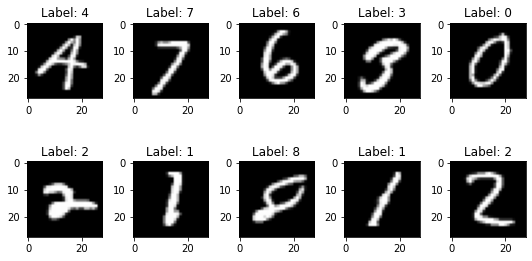

In [9]:
import matplotlib.pyplot as plt

num_row = 2
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    if np.shape(X_train[i])[2] == 1:
        ax.imshow(X_train[i,:,:,0], cmap='gray')
    else:
        ax.imshow(X_train[i])
    ax.set_title('Label: {}'.format(np.argmax(y_train[i])))
plt.tight_layout()
plt.show()

## Model setup

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import TensorBoard

In [11]:
def create_tunable_model(dropout_rate = 0.0,
                         kernel_sizes = 3,
                         activation_fun = 'relu'):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(kernel_sizes,kernel_sizes), activation=activation_fun, input_shape=(28,28,1)))
    model.add(Conv2D(32, kernel_size=(kernel_sizes,kernel_sizes), activation=activation_fun ))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation=activation_fun))
    model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.001), metrics=['accuracy'])
    return model

In [12]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

keras_estimator = KerasClassifier(build_fn = create_tunable_model)

early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.1, patience = 5, verbose = 0)
callbacks = [early_stop]

keras_fit_params = {   
    #'callbacks': callbacks,
    'epochs': 50,
    'batch_size': 32,
    'validation_data': (X_validation, y_validation),
    'verbose': 2
}

keras_param_options = {
    'dropout_rate': [0, 0.2, 0.5],
    'kernel_sizes': [3, 5],  
    'activation_fun': ['relu', 'tanh']
}

## Grid Search

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [13]:
from sklearn.model_selection import GridSearchCV
gridSearch_model = GridSearchCV(
                        keras_estimator,
                        param_grid = keras_param_options,
                        scoring = 'neg_log_loss',
                        cv = 3,  # Cross-val num of folds
                        n_jobs = 1,
                        verbose = 1)

In [14]:
gridSearch_model.fit(X_train, y_train, **keras_fit_params) # ~ a 1 hour 37 mins (on Tesla T4 GPU)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/50
1000/1000 - 3s - loss: 2.2037 - accuracy: 0.3987 - val_loss: 1.9722 - val_accuracy: 0.6451
Epoch 2/50
1000/1000 - 3s - loss: 1.0530 - accuracy: 0.7821 - val_loss: 0.5020 - val_accuracy: 0.8648
Epoch 3/50
1000/1000 - 3s - loss: 0.4181 - accuracy: 0.8825 - val_loss: 0.3605 - val_accuracy: 0.8964
Epoch 4/50
1000/1000 - 3s - loss: 0.3378 - accuracy: 0.9018 - val_loss: 0.3212 - val_accuracy: 0.9038
Epoch 5/50
1000/1000 - 3s - loss: 0.3012 - accuracy: 0.9125 - val_loss: 0.2974 - val_accuracy: 0.9116
Epoch 6/50
1000/1000 - 3s - loss: 0.2775 - accuracy: 0.9189 - val_loss: 0.2678 - val_accuracy: 0.9221
Epoch 7/50
1000/1000 - 3s - loss: 0.2573 - accuracy: 0.9241 - val_loss: 0.2506 - val_accuracy: 0.9265
Epoch 8/50
1000/1000 - 3s - loss: 0.2403 - accuracy: 0.9291 - val_loss: 0.2353 - val_accuracy: 0.9311
Epoch 9/50
1000/1000 - 3s - loss: 0.2259 - accuracy: 0.9342 - val_loss: 0.2213 - val_accuracy: 0.9364
Epoch 10/50
1000/1000 - 3s - loss: 0.2119 - accuracy: 0.9372 - val_loss: 0.2176 - 

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 92.7min finished


Epoch 1/50
1500/1500 - 5s - loss: 1.6902 - accuracy: 0.4774 - val_loss: 0.6050 - val_accuracy: 0.8376
Epoch 2/50
1500/1500 - 4s - loss: 0.6302 - accuracy: 0.7999 - val_loss: 0.3723 - val_accuracy: 0.8942
Epoch 3/50
1500/1500 - 4s - loss: 0.4716 - accuracy: 0.8553 - val_loss: 0.3070 - val_accuracy: 0.9145
Epoch 4/50
1500/1500 - 4s - loss: 0.3986 - accuracy: 0.8783 - val_loss: 0.2622 - val_accuracy: 0.9247
Epoch 5/50
1500/1500 - 4s - loss: 0.3466 - accuracy: 0.8951 - val_loss: 0.2312 - val_accuracy: 0.9341
Epoch 6/50
1500/1500 - 4s - loss: 0.3100 - accuracy: 0.9065 - val_loss: 0.2100 - val_accuracy: 0.9407
Epoch 7/50
1500/1500 - 4s - loss: 0.2803 - accuracy: 0.9159 - val_loss: 0.1910 - val_accuracy: 0.9448
Epoch 8/50
1500/1500 - 4s - loss: 0.2589 - accuracy: 0.9221 - val_loss: 0.1756 - val_accuracy: 0.9506
Epoch 9/50
1500/1500 - 4s - loss: 0.2399 - accuracy: 0.9285 - val_loss: 0.1642 - val_accuracy: 0.9532
Epoch 10/50
1500/1500 - 4s - loss: 0.2235 - accuracy: 0.9337 - val_loss: 0.1528 - 

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4767dac7f0>,
             iid='deprecated', n_jobs=1,
             param_grid={'activation_fun': ['relu', 'tanh'],
                         'dropout_rate': [0, 0.2, 0.5],
                         'kernel_sizes': [3, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=1)

In [15]:
print("Best parameters are:")
print(gridSearch_model.best_params_)
print("With score (greater-better):")
print(gridSearch_model.best_score_)

Best parameters are:
{'activation_fun': 'relu', 'dropout_rate': 0.2, 'kernel_sizes': 5}
With score (greater-better):
-0.07340872630391877


In [16]:
preds = gridSearch_model.predict(X_test)
preds[0]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


7

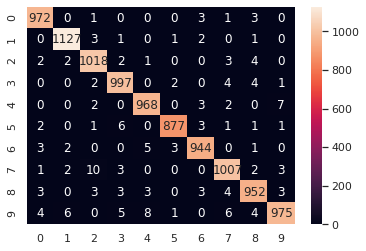

In [17]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(np.argmax(y_test,axis=1), preds)

import seaborn as sns; sns.set()
sns.heatmap(conf, annot=True, fmt='d')

## Random Search

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [18]:
from sklearn.model_selection import RandomizedSearchCV
randomSearch_model = RandomizedSearchCV(
                                keras_estimator,
                                param_distributions = keras_param_options,
                                scoring = 'neg_log_loss',
                                n_iter = 3, 
                                cv = 3,  # Cross-val num of folds
                                n_jobs = 1,
                                verbose = 1)

In [19]:
randomSearch_model.fit(X_train, y_train, **keras_fit_params) # ~ 28 min (on Tesla T4 GPU)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 - 3s - loss: 1.4285 - accuracy: 0.6877 - val_loss: 0.7278 - val_accuracy: 0.8453
Epoch 2/50
1000/1000 - 3s - loss: 0.5621 - accuracy: 0.8668 - val_loss: 0.4675 - val_accuracy: 0.8798
Epoch 3/50
1000/1000 - 3s - loss: 0.4208 - accuracy: 0.8901 - val_loss: 0.3885 - val_accuracy: 0.8947
Epoch 4/50
1000/1000 - 3s - loss: 0.3627 - accuracy: 0.9012 - val_loss: 0.3465 - val_accuracy: 0.9047
Epoch 5/50
1000/1000 - 3s - loss: 0.3275 - accuracy: 0.9093 - val_loss: 0.3165 - val_accuracy: 0.9137
Epoch 6/50
1000/1000 - 3s - loss: 0.3023 - accuracy: 0.9154 - val_loss: 0.2949 - val_accuracy: 0.9179
Epoch 7/50
1000/1000 - 3s - loss: 0.2825 - accuracy: 0.9202 - val_loss: 0.2770 - val_accuracy: 0.9227
Epoch 8/50
1000/1000 - 3s - loss: 0.2659 - accuracy: 0.9247 - val_loss: 0.2624 - val_accuracy: 0.9253
Epoch 9/50
1000/1000 - 3s - loss: 0.2517 - accuracy: 0.9284 - val_loss: 0.2490 - val_accuracy: 0.9299
Epoch 10/50
1000/1000 - 3s - loss: 0.2390 - accuracy: 0.9318 - val_loss: 0.2380 - val_accurac

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 23.5min finished


Epoch 1/50
1500/1500 - 5s - loss: 1.5726 - accuracy: 0.5663 - val_loss: 0.5076 - val_accuracy: 0.8522
Epoch 2/50
1500/1500 - 4s - loss: 0.3913 - accuracy: 0.8879 - val_loss: 0.3248 - val_accuracy: 0.9087
Epoch 3/50
1500/1500 - 4s - loss: 0.2988 - accuracy: 0.9121 - val_loss: 0.2682 - val_accuracy: 0.9218
Epoch 4/50
1500/1500 - 4s - loss: 0.2538 - accuracy: 0.9259 - val_loss: 0.2427 - val_accuracy: 0.9294
Epoch 5/50
1500/1500 - 4s - loss: 0.2244 - accuracy: 0.9338 - val_loss: 0.2111 - val_accuracy: 0.9371
Epoch 6/50
1500/1500 - 4s - loss: 0.2024 - accuracy: 0.9401 - val_loss: 0.1851 - val_accuracy: 0.9477
Epoch 7/50
1500/1500 - 4s - loss: 0.1842 - accuracy: 0.9458 - val_loss: 0.1735 - val_accuracy: 0.9505
Epoch 8/50
1500/1500 - 4s - loss: 0.1705 - accuracy: 0.9498 - val_loss: 0.1673 - val_accuracy: 0.9520
Epoch 9/50
1500/1500 - 4s - loss: 0.1584 - accuracy: 0.9527 - val_loss: 0.1553 - val_accuracy: 0.9574
Epoch 10/50
1500/1500 - 4s - loss: 0.1483 - accuracy: 0.9561 - val_loss: 0.1452 - 

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4767dac7f0>,
                   iid='deprecated', n_iter=3, n_jobs=1,
                   param_distributions={'activation_fun': ['relu', 'tanh'],
                                        'dropout_rate': [0, 0.2, 0.5],
                                        'kernel_sizes': [3, 5]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='neg_log_loss', verbose=1)

In [20]:
print("Best parameters are:")
print(randomSearch_model.best_params_)
print("With score (greater-better):")
print(randomSearch_model.best_score_)

Best parameters are:
{'kernel_sizes': 5, 'dropout_rate': 0, 'activation_fun': 'relu'}
With score (greater-better):
-0.08644670300061992


In [21]:
preds = randomSearch_model.predict(X_test)
preds[0]

7

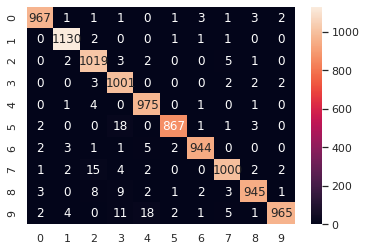

In [22]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(np.argmax(y_test,axis=1), preds)

import seaborn as sns; sns.set()
sns.heatmap(conf, annot=True, fmt='d')

## Bayesian Optimization

https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

In [23]:
!pip install scikit-optimize

     |████████████████████████████████| 102kB 6.5MB/s 


In [25]:
from skopt import BayesSearchCV
bayesSearch_model = BayesSearchCV(
                        keras_estimator,
                        search_spaces = keras_param_options,
                        scoring = 'neg_log_loss',
                        cv = 3,  # Cross-val num of folds
                        n_jobs = 1,
                        verbose = 1)

In [26]:
bayesSearch_model.fit(X_train, y_train) # ~ 10 mins (on Tesla T4 GPU)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.6505 - accuracy: 0.5722


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
1000/1000 [==============================] - 3s 3ms/step - loss: 2.1224 - accuracy: 0.3058


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
1000/1000 [==============================] - 3s 3ms/step - loss: 1.7005 - accuracy: 0.6029


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
1000/1000 [==============================] - 3s 3ms/step - loss: 2.1968 - accuracy: 0.3932


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
1000/1000 [==============================] - 3s 3ms/step - loss: 2.0356 - accuracy: 0.3657


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
1000/1000 [==============================] - 3s 3ms/step - loss: 2.1352 - accuracy: 0.3707


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
1000/1000 [==============================] - 3s 3ms/step - loss: 2.1960 - accuracy: 0.2596


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
1000/1000 [==============================] - 3s 3ms/step - loss: 1.6458 - accuracy: 0.5851


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
1000/1000 [==============================] - 3s 3ms/step - loss: 2.2672 - accuracy: 0.2440


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 2.1699 - accuracy: 0.2304


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5625 - accuracy: 0.5770


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.6651 - accuracy: 0.4758


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.8572 - accuracy: 0.4211


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4805 - accuracy: 0.6475


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.8s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5035 - accuracy: 0.6552


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5172 - accuracy: 0.6335


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4814 - accuracy: 0.6607


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.5s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5197 - accuracy: 0.6305


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5146 - accuracy: 0.6335


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.6s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4972 - accuracy: 0.6379


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4840 - accuracy: 0.6376


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5466 - accuracy: 0.6186


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.6s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4831 - accuracy: 0.6607


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.0s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4790 - accuracy: 0.6472


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.6s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4396 - accuracy: 0.6681


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4859 - accuracy: 0.6358


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.6s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4539 - accuracy: 0.6600


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5573 - accuracy: 0.5923


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5374 - accuracy: 0.6233


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4682 - accuracy: 0.6518


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5532 - accuracy: 0.5759


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5504 - accuracy: 0.6311


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.0s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4753 - accuracy: 0.6465


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4718 - accuracy: 0.6525


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.0s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.6533 - accuracy: 0.5522


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.3s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5982 - accuracy: 0.6161


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4751 - accuracy: 0.6363


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.6s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4613 - accuracy: 0.6703


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5574 - accuracy: 0.5770


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5173 - accuracy: 0.6314


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5658 - accuracy: 0.6188


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.6s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.4927 - accuracy: 0.5858


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.3642 - accuracy: 0.6693


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.6503 - accuracy: 0.6177


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.3799 - accuracy: 0.6819


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.8005 - accuracy: 0.4203


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5111 - accuracy: 0.6016


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5445 - accuracy: 0.5830


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5951 - accuracy: 0.5739


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.3s finished
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1000/1000 [==============================] - 3s 3ms/step - loss: 1.5715 - accuracy: 0.6527


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.8s finished


1500/1500 [==============================] - 4s 3ms/step - loss: 1.2262 - accuracy: 0.6979


BayesSearchCV(cv=3, error_score='raise',
              estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f4767dac7f0>,
              fit_params=None, iid=True, n_iter=50, n_jobs=1, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
              refit=True, return_train_score=False, scoring='neg_log_loss',
              search_spaces={'activation_fun': ['relu', 'tanh'],
                             'dropout_rate': [0, 0.2, 0.5],
                             'kernel_sizes': [3, 5]},
              verbose=1)

In [27]:
print("Best parameters are:")
print(bayesSearch_model.best_params_)
print("With score (greater-better):")
print(bayesSearch_model.best_score_)

Best parameters are:
OrderedDict([('activation_fun', 'tanh'), ('dropout_rate', 0.0), ('kernel_sizes', 5)])
With score (greater-better):
-0.7244255808429055


In [28]:
preds = bayesSearch_model.predict(X_test)
preds[0]

7

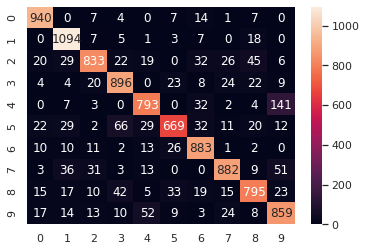

In [29]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(np.argmax(y_test,axis=1), preds)

import seaborn as sns; sns.set()
sns.heatmap(conf, annot=True, fmt='d')

## AutoKeras

https://autokeras.com/tutorial/customized/

In [30]:
!pip3 install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc4
!pip3 install autokeras

  Cloning https://github.com/keras-team/keras-tuner.git (to revision 1.0.2rc4) to /tmp/pip-req-build-rgyxdy5h
  Running command git clone -q https://github.com/keras-team/keras-tuner.git /tmp/pip-req-build-rgyxdy5h
  Running command git checkout -q 3189ab613e022d53c511348a10aed69d821f3cd1
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2rc4-cp36-none-any.whl size=92365 sha256=a10f7dcb94cb2fe1d8bd623c4fe0f4fef56907a5e7e79896e2a6ea8bf028184a
  Stored in directory: /tmp/pip-ephem-wheel-cache-c2tq7o9z/wheels/f6/84/20/5b1be7aae47964b49fa6b39881440a3a23d2a73d84bc097aeb
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=4f29bd0e07783b69c05c74c31deb2d45051977944452a09a50b4ea739d811caa
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
     |████████████████████████████████| 163kB 14.6MB/s 


In [38]:
import autokeras as ak

input_node = ak.ImageInput()
output_node = ak.ConvBlock()(input_node)
output_node1 = ak.ConvBlock()(output_node)
output_node2 = ak.DenseBlock()(output_node1)
output_node3 = ak.DenseBlock()(output_node2)
output_node = ak.ClassificationHead(num_classes=10)(output_node3)

clf = ak.ImageClassifier(max_trials=1)

INFO:tensorflow:Reloading Oracle from existing project ./image_classifier/oracle.json


In [39]:
clf.fit(X_train, y_train, epochs=10) # ~ 15 mins (on Tesla T4 GPU)

Trial 1 Complete [00h 08m 20s]
val_loss: 0.05199024826288223

Best val_loss So Far: 0.05199024826288223
Total elapsed time: 00h 08m 20s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
1500/1500 [==============================] - 56s 38ms/step - loss: 0.3752 - accuracy: 0.9115
Epoch 2/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.3322 - accuracy: 0.9235
Epoch 3/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.1387 - accuracy: 0.9647
Epoch 4/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.2344 - accuracy: 0.9448
Epoch 5/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.2672 - accuracy: 0.9388
Epoch 6/10
1500/1500 [==============================] - 56s 37ms/step - loss: 0.1317 - accuracy: 0.9655
Epoch 7/10
1500/1500 [==============================] - 57s 38ms/step - loss: 0.1619 - accuracy: 0.9585
Epoch 8/10
1500/1500 [==============================] - 56s 38ms/step - loss: 0.0680 - accuracy: 0

In [40]:
model = clf.export_model()

print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
cast_to_float32 (CastToFloat32) (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
resizing (Resizing)             (None, 32, 32, 1)    0           cast_to_float32[0][0]            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 32, 32, 3)    0           resizing[0][0]                   
                                                                 resizing[0][0]        

In [41]:
preds = clf.predict(X_test)

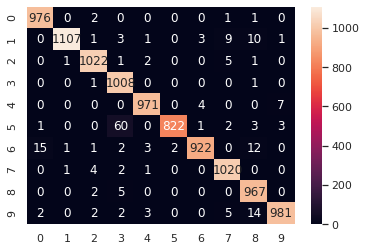

In [42]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(preds,axis=1))

import seaborn as sns; sns.set()
sns.heatmap(conf, annot=True, fmt='d')